# Promotion Bump Assignment

Cihat SARI
cihatsari93@gmail.com

# Library import

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import ttest_ind, zscore
import statsmodels.api as sm

# Data Preparation

In [2]:
assignment4_1a_df = pd.read_csv("assignment4.1a.csv")

In [3]:
assignment4_1a_df.head()

,Date,StoreCode,ProductCode,SalesQuantity
0,2015-01-01,8,9,-1
1,2015-01-01,131,9,1
2,2015-01-01,144,9,2
3,2015-01-01,203,9,2
4,2015-01-01,256,9,0


In [4]:
assignment4_1a_df.tail()

,Date,StoreCode,ProductCode,SalesQuantity
1873613,2015-07-30,292,315,0
1873614,2015-07-31,12,315,1
1873615,2015-07-31,104,315,1
1873616,2015-07-31,261,315,1
1873617,2015-07-31,295,315,1


In [5]:
assignment4_1a_df.shape

(1873618, 4)

## Attach promotions to main dataset

In [6]:
promotion_dates_df = pd.read_csv("PromotionDates.csv")

In [7]:
promotion_dates_df

,Period,StartDate,EndDate
0,Promo1,2/10/2015,2/17/2015
1,Promo2,3/15/2015,3/22/2015
2,Promo3,5/24/2015,6/1/2015
3,Promo4,6/21/2015,6/28/2015
4,Promo5,1/9/2015,6/9/2015
5,Promo6,20/11/2015,27/11/2015


<b>Date formats seems different so I corrected them as same format.

In [8]:
# Check the data types of the columns
print(promotion_dates_df.dtypes)

Period       object
StartDate    object
EndDate      object
dtype: object


In [9]:
promotion_dates_df.loc[:3, 'StartDate'] = pd.to_datetime(promotion_dates_df.loc[:3, 'StartDate'], format='%m/%d/%Y', errors='coerce')
promotion_dates_df.loc[:3, 'EndDate'] = pd.to_datetime(promotion_dates_df.loc[:3, 'EndDate'], format='%m/%d/%Y', errors='coerce')
promotion_dates_df.loc[4:, 'StartDate'] = pd.to_datetime(promotion_dates_df.loc[4:, 'StartDate'], format='%d/%m/%Y', errors='coerce')
promotion_dates_df.loc[4:, 'EndDate'] = pd.to_datetime(promotion_dates_df.loc[4:, 'EndDate'], format='%d/%m/%Y', errors='coerce')

In [10]:
promotion_dates_df

,Period,StartDate,EndDate
0,Promo1,2015-02-10 00:00:00,2015-02-17 00:00:00
1,Promo2,2015-03-15 00:00:00,2015-03-22 00:00:00
2,Promo3,2015-05-24 00:00:00,2015-06-01 00:00:00
3,Promo4,2015-06-21 00:00:00,2015-06-28 00:00:00
4,Promo5,2015-09-01 00:00:00,2015-09-06 00:00:00
5,Promo6,2015-11-20 00:00:00,2015-11-27 00:00:00


In [11]:
# Convert dates to date format
assignment4_1a_df['Date'] = pd.to_datetime(assignment4_1a_df['Date'], format='%Y/%m/%d', errors='coerce')

In [12]:
assignment4_1a_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1873618 entries, 0 to 1873617
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Date           datetime64[ns]
 1   StoreCode      int64         
 2   ProductCode    int64         
 3   SalesQuantity  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 57.2 MB


In [13]:
# Expanding promotion dates to apply on main dataset
promo_expanded = pd.DataFrame()#Empty Dataframe

for _, promo in promotion_dates_df.iterrows():
    promo_range = pd.date_range(promo['StartDate'], promo['EndDate'])#Promotion date range
    temp_df = pd.DataFrame({'Date': promo_range, 'Promotion': promo['Period']})#temporary dataframe including promotion dates
    promo_expanded = pd.concat([promo_expanded, temp_df])#Adding Each promotion date interval to same dataframe

#Based on main dataset's dates adding promotion dates to main dataset
assignment4_1a_df = pd.merge(assignment4_1a_df, promo_expanded, on='Date', how='left')

# Not promotion days named as NoPromo
assignment4_1a_df['Promotion'].fillna('NoPromo', inplace=True)

print(assignment4_1a_df.head())

        Date  StoreCode  ProductCode  SalesQuantity Promotion
0 2015-01-01          8            9             -1   NoPromo
1 2015-01-01        131            9              1   NoPromo
2 2015-01-01        144            9              2   NoPromo
3 2015-01-01        203            9              2   NoPromo
4 2015-01-01        256            9              0   NoPromo


In [14]:
assignment4_1a_df["Promotion"].unique()

array(['NoPromo', 'Promo1', 'Promo2', 'Promo3', 'Promo4'], dtype=object)

In [15]:
#To see where this data goes
assignment4_1a_df.tail()

,Date,StoreCode,ProductCode,SalesQuantity,Promotion
1873613,2015-07-30,292,315,0,NoPromo
1873614,2015-07-31,12,315,1,NoPromo
1873615,2015-07-31,104,315,1,NoPromo
1873616,2015-07-31,261,315,1,NoPromo
1873617,2015-07-31,295,315,1,NoPromo


In [16]:
#Inspecting the dataset
assignment4_1a_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1873618 entries, 0 to 1873617
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   Date           datetime64[ns]
 1   StoreCode      int64         
 2   ProductCode    int64         
 3   SalesQuantity  int64         
 4   Promotion      object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 85.8+ MB


In [17]:
#Desribing the dataframe to get some statistical information about the data
assignment4_1a_df["SalesQuantity"].describe()

count    1.873618e+06
mean     2.246632e+00
std      5.028994e+00
min     -6.000000e+01
25%      0.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      9.120000e+02
Name: SalesQuantity, dtype: float64

In [18]:
#Check if there is null values
assignment4_1a_df.isnull().sum()

Date             0
StoreCode        0
ProductCode      0
SalesQuantity    0
Promotion        0
dtype: int64

In [19]:
#Check if there is na values
assignment4_1a_df.isna().sum()

Date             0
StoreCode        0
ProductCode      0
SalesQuantity    0
Promotion        0
dtype: int64

In [20]:
#Check if there is any duplicated data
assignment4_1a_df.duplicated().sum()

0

In [21]:
#To see the number of different stores and products
assignment4_1a_df.nunique()

Date             212
StoreCode        340
ProductCode      317
SalesQuantity    177
Promotion          5
dtype: int64

<AxesSubplot:xlabel='StoreCode'>

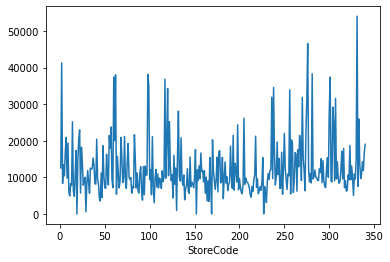

In [22]:
#Total Sales per store
store_sales = assignment4_1a_df.groupby('StoreCode')['SalesQuantity'].sum()
store_sales.plot()

Text(0.5, 1.0, 'Mean Sales Quantity per Store')

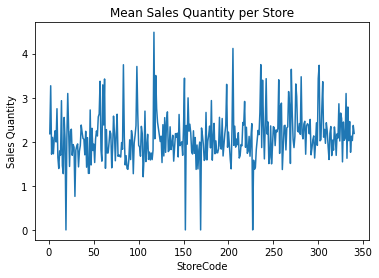

In [23]:
#Mean Sales per store
mean_store_sales = assignment4_1a_df.groupby('StoreCode')['SalesQuantity'].mean()
mean_store_sales.plot()
plt.ylabel("Sales Quantity")
plt.title("Mean Sales Quantity per Store")

<AxesSubplot:xlabel='ProductCode'>

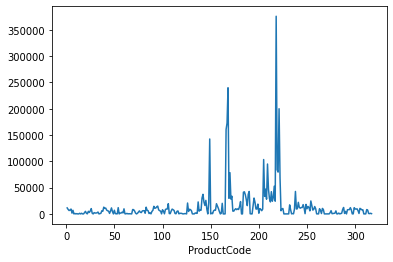

In [24]:
#Total sales per product
product_sales = assignment4_1a_df.groupby('ProductCode')['SalesQuantity'].sum()
product_sales.plot()

Text(0.5, 1.0, 'Mean Sales per Product')

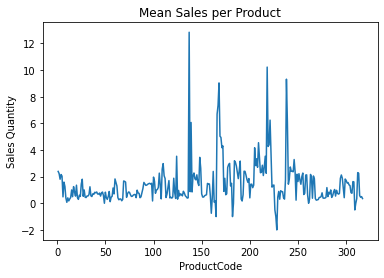

In [25]:
#Mean sales per product
mean_product_sales = assignment4_1a_df.groupby('ProductCode')['SalesQuantity'].mean()
mean_product_sales.plot()
plt.ylabel("Sales Quantity")
plt.title("Mean Sales per Product")

<AxesSubplot:xlabel='Date', ylabel='SalesQuantity'>

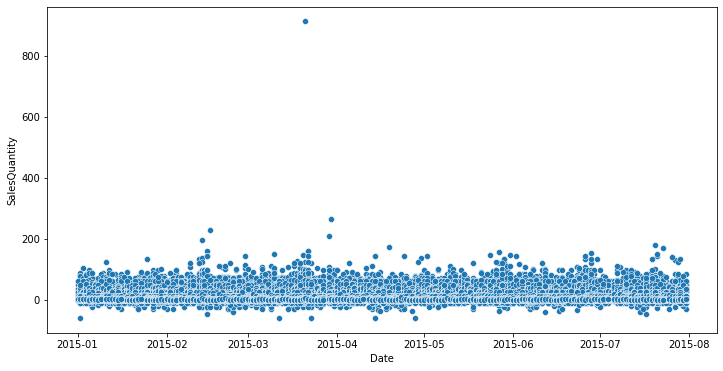

In [26]:
#Scatter plot of SalesQuantity
plt.figure(figsize=(12,6))
sns.scatterplot(data=assignment4_1a_df, x=assignment4_1a_df["Date"], y='SalesQuantity')

There are outliers as we can see from above graph

In [27]:
#Get rid of Outliers
assignment4_1a_df = assignment4_1a_df[assignment4_1a_df['SalesQuantity'] < 200]

<AxesSubplot:xlabel='Date', ylabel='SalesQuantity'>

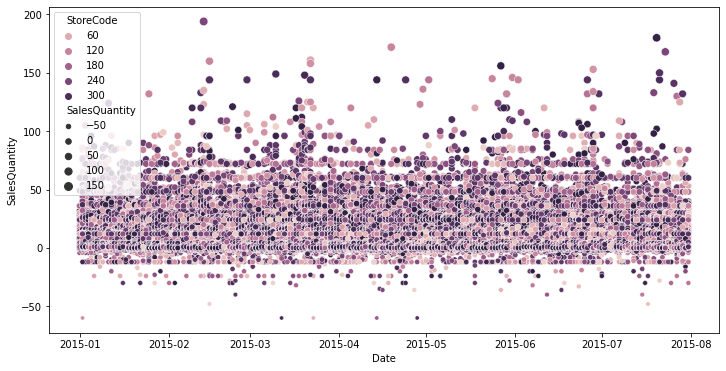

In [28]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=assignment4_1a_df, x=assignment4_1a_df["Date"], y='SalesQuantity', size='SalesQuantity', hue='StoreCode')

<AxesSubplot:xlabel='Date', ylabel='SalesQuantity'>

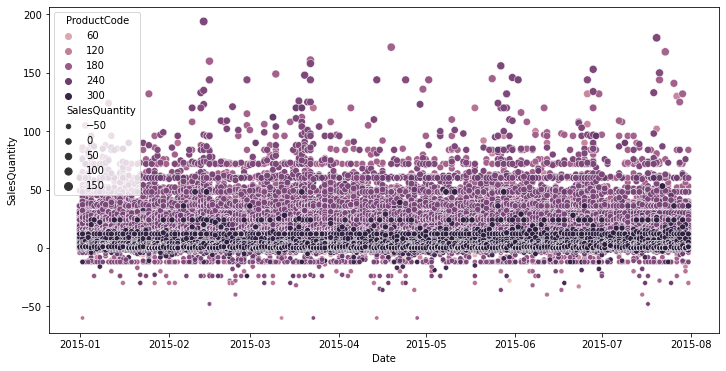

In [29]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=assignment4_1a_df, x=assignment4_1a_df["Date"], y='SalesQuantity', size='SalesQuantity', hue='ProductCode')

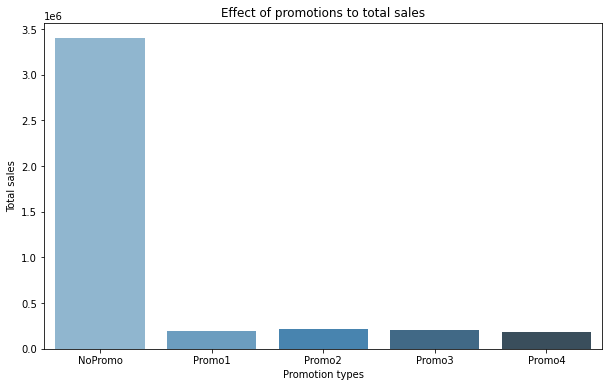

In [30]:
# Total sales per promotion
promo_sales = assignment4_1a_df.groupby('Promotion')['SalesQuantity'].sum().reset_index()

# Visualization with bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Promotion', y='SalesQuantity', data=promo_sales, palette='Blues_d')
plt.title('Effect of promotions to total sales')
plt.ylabel('Total sales')
plt.xlabel('Promotion types')
plt.show()

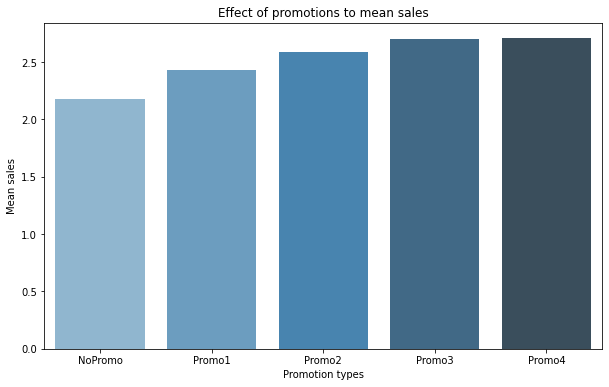

In [31]:
# Mean sales per promotion
promo_sales = assignment4_1a_df.groupby('Promotion')['SalesQuantity'].mean().reset_index()

# Visualization with bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Promotion', y='SalesQuantity', data=promo_sales, palette='Blues_d')
plt.title('Effect of promotions to mean sales')
plt.ylabel('Mean sales')
plt.xlabel('Promotion types')
plt.show()

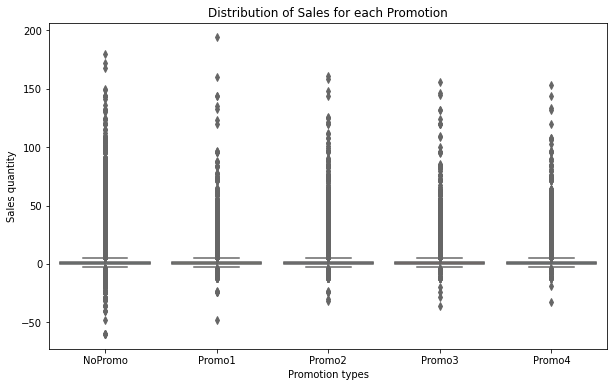

In [32]:
# Distribution of Sales for each Promotion
plt.figure(figsize=(10, 6))
sns.boxplot(x='Promotion', y='SalesQuantity', data=assignment4_1a_df, palette='Set3')
plt.title('Distribution of Sales for each Promotion')
plt.ylabel('Sales quantity')
plt.xlabel('Promotion types')
plt.show()

In [33]:
promo_store_sales = assignment4_1a_df.pivot_table(index='StoreCode', columns='Promotion', values='SalesQuantity', aggfunc='mean')
promo_store_sales.describe()

Promotion,NoPromo,Promo1,Promo2,Promo3,Promo4
count,340.000000,330.000000,332.000000,333.000000,331.000000
mean,2.043487,2.344836,2.471942,2.572881,2.562582
std,0.550803,0.774613,0.848226,0.877800,0.924925
min,0.000000,0.000000,0.823171,0.917476,0.000000
25%,1.707462,1.784453,1.920207,1.984962,1.928399
50%,1.986020,2.295653,2.340523,2.408046,2.392308
75%,2.273788,2.767858,2.886776,3.038095,3.080769
max,4.222304,5.322581,5.711207,7.051414,6.416667


In [34]:
assignment4_1a_df["Month"] = assignment4_1a_df["Date"].dt.month
assignment4_1a_df["Year"] = assignment4_1a_df["Date"].dt.year
assignment4_1a_df["Dayofmonth"] = assignment4_1a_df["Date"].dt.day
assignment4_1a_df["Weekofyear"] = assignment4_1a_df["Date"].dt.week
assignment4_1a_df

,Date,StoreCode,ProductCode,SalesQuantity,Promotion,Month,Year,Dayofmonth,Weekofyear
0,2015-01-01,8,9,-1,NoPromo,1,2015,1,1
1,2015-01-01,131,9,1,NoPromo,1,2015,1,1
2,2015-01-01,144,9,2,NoPromo,1,2015,1,1
3,2015-01-01,203,9,2,NoPromo,1,2015,1,1
4,2015-01-01,256,9,0,NoPromo,1,2015,1,1
...,...,...,...,...,...,...,...,...,...
1873613,2015-07-30,292,315,0,NoPromo,7,2015,30,31
1873614,2015-07-31,12,315,1,NoPromo,7,2015,31,31
1873615,2015-07-31,104,315,1,NoPromo,7,2015,31,31
1873616,2015-07-31,261,315,1,NoPromo,7,2015,31,31


In [35]:
mothly_total_sales = assignment4_1a_df.groupby("Month")["SalesQuantity"].sum()
weekly_total_sales = assignment4_1a_df.groupby("Weekofyear")["SalesQuantity"].sum()
mothly_average_sales = assignment4_1a_df.groupby("Month")["SalesQuantity"].mean()
weekly_average_sales = assignment4_1a_df.groupby("Weekofyear")["SalesQuantity"].mean()

In [36]:
mothly_total_sales

Month
1    552448
2    586419
3    694956
4    624923
5    655995
6    585542
7    507432
Name: SalesQuantity, dtype: int64

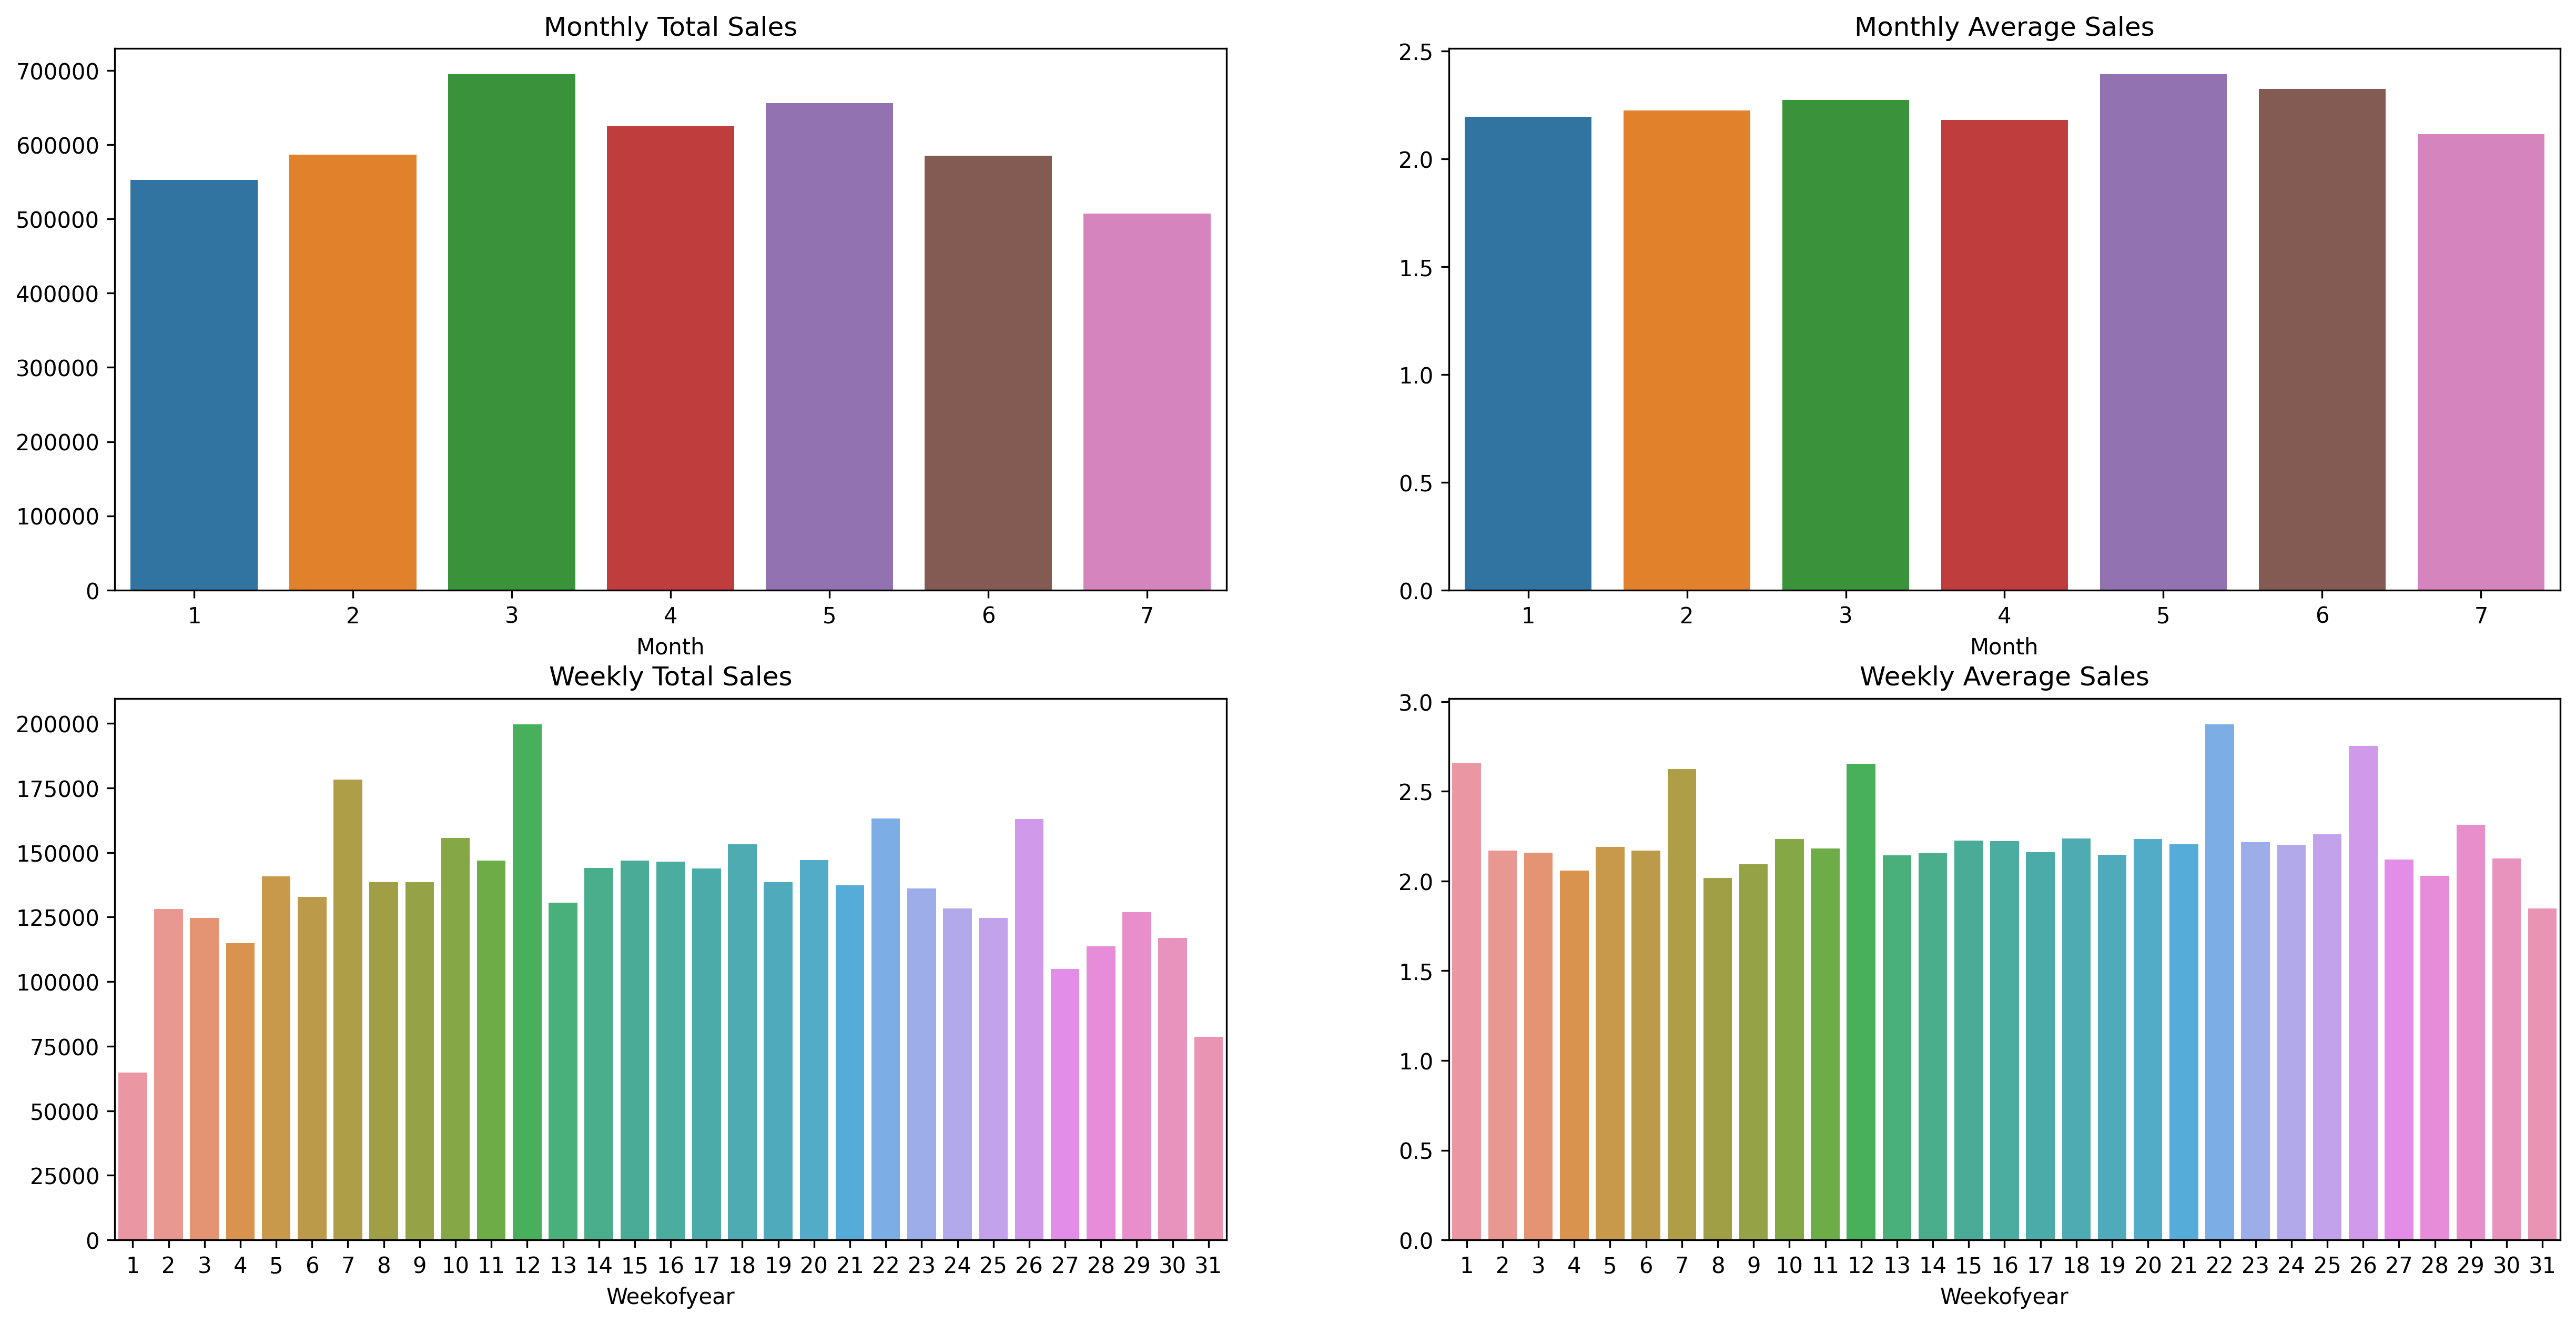

In [37]:
#Visualization of monthly and weekly total, mean sales
fig, axs = plt.subplots(ncols=2,nrows=2,figsize=(20, 10),dpi=300)
sns.barplot(x=mothly_total_sales.index,y=mothly_total_sales.values,ax=axs[0][0]).set(title='Monthly Total Sales')
sns.barplot(x=mothly_average_sales.index,y=mothly_average_sales.values,ax=axs[0][1]).set(title='Monthly Average Sales')
sns.barplot(x=weekly_total_sales.index,y=weekly_total_sales.values,ax=axs[1][0]).set(title='Weekly Total Sales')
sns.barplot(x=weekly_average_sales.index,y=weekly_average_sales.values,ax=axs[1][1]).set(title='Weekly Average Sales')
plt.show()

## Clustering of Products and Stores

## a.	What are your criteria for separating Fast, Medium and Slow items? Why?

In [38]:
assignment4_1a_df

,Date,StoreCode,ProductCode,SalesQuantity,Promotion,Month,Year,Dayofmonth,Weekofyear
0,2015-01-01,8,9,-1,NoPromo,1,2015,1,1
1,2015-01-01,131,9,1,NoPromo,1,2015,1,1
2,2015-01-01,144,9,2,NoPromo,1,2015,1,1
3,2015-01-01,203,9,2,NoPromo,1,2015,1,1
4,2015-01-01,256,9,0,NoPromo,1,2015,1,1
...,...,...,...,...,...,...,...,...,...
1873613,2015-07-30,292,315,0,NoPromo,7,2015,30,31
1873614,2015-07-31,12,315,1,NoPromo,7,2015,31,31
1873615,2015-07-31,104,315,1,NoPromo,7,2015,31,31
1873616,2015-07-31,261,315,1,NoPromo,7,2015,31,31


In [39]:
# Sales at non-promotion periods
non_promo_sales = assignment4_1a_df[assignment4_1a_df['Promotion'] == 'NoPromo']

# Weekly_sales of each product
weekly_sales = non_promo_sales.groupby(['ProductCode', "Weekofyear"])['SalesQuantity'].sum().reset_index()

# Weekly mean sales for each product
average_sales_per_product = weekly_sales.groupby('ProductCode')['SalesQuantity'].mean().reset_index()
average_sales_per_product.columns = ['ProductCode', 'AvgWeeklySales']

# Seperating fast, medium and slow items
average_sales_per_product['Rank'] = average_sales_per_product['AvgWeeklySales'].rank(ascending=False)
average_sales_per_product['Category'] = pd.qcut(average_sales_per_product['Rank'], 3, labels=['Fast', 'Medium', 'Slow'])
average_sales_per_product

,ProductCode,AvgWeeklySales,Rank,Category
0,1,336.964286,77.0,Fast
1,2,254.071429,113.0,Medium
2,3,184.750000,150.0,Medium
3,4,225.714286,136.0,Medium
4,5,272.392857,103.0,Fast
...,...,...,...,...
311,313,379.375000,66.0,Fast
312,314,23.964286,227.0,Slow
313,315,16.500000,240.0,Slow
314,316,34.785714,212.0,Slow


In [40]:
average_sales_per_product[average_sales_per_product.Category=="Fast"].describe()

,ProductCode,AvgWeeklySales,Rank
count,106.000000,106.000000,106.000000
mean,184.981132,981.795810,53.500000
std,70.236333,1473.343350,30.743563
min,1.000000,268.107143,1.000000
25%,146.500000,325.705357,27.250000
50%,195.500000,493.803571,53.500000
75%,236.500000,893.266071,79.750000
max,313.000000,10421.428571,106.000000


In [41]:
average_sales_per_product[average_sales_per_product.Category=="Medium"].describe()

,ProductCode,AvgWeeklySales,Rank
count,105.000000,105.000000,105.000000
mean,132.304762,165.019812,159.000000
std,94.447597,71.546095,30.454885
min,2.000000,35.500000,107.000000
25%,57.000000,107.294118,133.000000
50%,103.000000,177.928571,159.000000
75%,202.000000,229.285714,185.000000
max,312.000000,266.714286,211.000000


In [42]:
average_sales_per_product[average_sales_per_product.Category=="Slow"].describe()

,ProductCode,AvgWeeklySales,Rank
count,105.000000,105.000000,105.000000
mean,158.495238,9.830844,264.000000
std,100.577766,11.083533,30.452517
min,8.000000,-2.000000,212.000000
25%,65.000000,1.130435,238.000000
50%,147.000000,5.000000,263.000000
75%,265.000000,18.000000,290.000000
max,317.000000,34.785714,315.500000


## b.	What are your criteria for separating Fast, Medium and Slow Stores? Why?

In [43]:
# Weekly_sales of each store
weekly_sales_store = non_promo_sales.groupby(['StoreCode', "Weekofyear"])['SalesQuantity'].sum().reset_index()

# Weekly mean sales for each store
average_sales_per_store = weekly_sales_store.groupby('StoreCode')['SalesQuantity'].mean().reset_index()
average_sales_per_store.columns = ['StoreCode', 'AvgWeeklySales']

# Seperating fast, medium and slow items
average_sales_per_store['Rank'] = average_sales_per_store['AvgWeeklySales'].rank(ascending=False)
average_sales_per_store['Category'] = pd.qcut(average_sales_per_store['Rank'], 3, labels=['Fast', 'Medium', 'Slow'])
average_sales_per_store

,StoreCode,AvgWeeklySales,Rank,Category
0,1,370.500000,107.0,Fast
1,2,1205.928571,3.0,Fast
2,3,242.250000,238.0,Slow
3,4,373.535714,105.0,Fast
4,5,303.892857,156.0,Medium
...,...,...,...,...
335,336,315.571429,148.0,Medium
336,337,409.178571,96.0,Fast
337,338,344.035714,127.0,Medium
338,339,480.678571,71.0,Fast


In [44]:
average_sales_per_store[average_sales_per_store.Category=="Fast"].describe()

,StoreCode,AvgWeeklySales,Rank
count,114.000000,114.000000,114.000000
mean,169.447368,602.380272,57.500000
std,107.453229,236.562021,33.052988
min,1.000000,360.555556,1.000000
25%,69.750000,435.741071,29.250000
50%,168.500000,526.071429,57.500000
75%,267.750000,683.810620,85.750000
max,340.000000,1546.107143,114.000000


In [45]:
average_sales_per_store[average_sales_per_store.Category=="Medium"].describe()

,StoreCode,AvgWeeklySales,Rank
count,113.000000,113.000000,113.000000
mean,188.168142,296.867962,171.000000
std,93.539612,30.998517,32.764037
min,5.000000,252.785714,115.000000
25%,112.000000,271.178571,143.000000
50%,183.000000,290.071429,171.000000
75%,278.000000,320.142857,199.000000
max,338.000000,360.250000,227.000000


In [46]:
average_sales_per_store[average_sales_per_store.Category=="Slow"].describe()

,StoreCode,AvgWeeklySales,Rank
count,113.000000,113.000000,113.00000
mean,153.893805,187.624757,284.00000
std,90.832495,53.983807,32.76356
min,3.000000,0.000000,228.00000
25%,74.000000,165.321429,256.00000
50%,164.000000,203.321429,284.00000
75%,221.000000,226.892857,312.00000
max,332.000000,252.535714,338.50000


In [47]:
# Combining product groups with the data
assignment4_1a_df = assignment4_1a_df.merge(average_sales_per_product[['ProductCode', 'Category']], on='ProductCode', how='left')
assignment4_1a_df.rename(columns={'Category': 'ProductCategory'}, inplace=True)

# Combining store groups with the data
assignment4_1a_df = assignment4_1a_df.merge(average_sales_per_store[['StoreCode', 'Category']], on='StoreCode', how='left')
assignment4_1a_df.rename(columns={'Category': 'StoreCategory'}, inplace=True)

print(assignment4_1a_df.head())

        Date  StoreCode  ProductCode  SalesQuantity Promotion  Month  Year  \
0 2015-01-01          8            9             -1   NoPromo      1  2015   
1 2015-01-01        131            9              1   NoPromo      1  2015   
2 2015-01-01        144            9              2   NoPromo      1  2015   
3 2015-01-01        203            9              2   NoPromo      1  2015   
4 2015-01-01        256            9              0   NoPromo      1  2015   

   Dayofmonth  Weekofyear ProductCategory StoreCategory  
0           1           1            Slow        Medium  
1           1           1            Slow          Fast  
2           1           1            Slow          Slow  
3           1           1            Slow          Slow  
4           1           1            Slow          Fast  


## c.	Which items experienced the biggest sale increase during promotions?

In [48]:
# Sales averages with promotion and non-promotion periods
promo_sales = assignment4_1a_df[assignment4_1a_df['Promotion'] != 'NoPromo']
non_promo_sales = assignment4_1a_df[assignment4_1a_df['Promotion'] == 'NoPromo']

# Sale averages base on product
promo_avg_sales = promo_sales.groupby('ProductCode')['SalesQuantity'].mean().reset_index()
non_promo_avg_sales = non_promo_sales.groupby('ProductCode')['SalesQuantity'].mean().reset_index()

# Combining to calculate sale increase
sales_increase = promo_avg_sales.merge(non_promo_avg_sales, on='ProductCode', suffixes=('_promo', '_non_promo'))
sales_increase['SalesIncrease'] = sales_increase['SalesQuantity_promo'] - sales_increase['SalesQuantity_non_promo']

# Sort by sale increase
sales_increase = sales_increase.sort_values(by='SalesIncrease', ascending=False)
print(sales_increase.head(10))

     ProductCode  SalesQuantity_promo  SalesQuantity_non_promo  SalesIncrease
207          218            13.712299                 9.497770       4.214529
215          226             1.000000                -2.000000       3.000000
210          221             8.376676                 5.824391       2.552284
225          238            10.967062                 8.986409       1.980653
198          209             6.160011                 4.221652       1.938359
194          205             5.643238                 3.870475       1.772763
208          219             5.645890                 3.983091       1.662799
209          220             5.764725                 4.113117       1.651608
55            61             3.000000                 1.392593       1.607407
226          239             7.375000                 5.830203       1.544797


## d.	Are there stores that have higher promotion reaction?

In [49]:
# Sales averages with promotion and non-promotion periods based on stores
promo_avg_sales_store = promo_sales.groupby('StoreCode')['SalesQuantity'].mean().reset_index()
non_promo_avg_sales_store = non_promo_sales.groupby('StoreCode')['SalesQuantity'].mean().reset_index()

# Combining to calculate sale increase 
store_sales_increase = promo_avg_sales_store.merge(non_promo_avg_sales_store, on='StoreCode', suffixes=('_promo', '_non_promo'))
store_sales_increase['SalesIncrease'] = store_sales_increase['SalesQuantity_promo'] - store_sales_increase['SalesQuantity_non_promo']

# Sort by sale increase
store_sales_increase = store_sales_increase.sort_values(by='SalesIncrease', ascending=False)
print(store_sales_increase.head(10))

     StoreCode  SalesQuantity_promo  SalesQuantity_non_promo  SalesIncrease
90          92             4.760684                 1.846047       2.914637
201        205             5.380863                 3.861573       1.519290
177        181             4.157635                 2.711883       1.445752
115        117             5.547302                 4.222304       1.324998
152        155             4.104735                 2.785772       1.318962
251        256             4.404311                 3.116119       1.288192
19          21             4.110595                 2.897963       1.212632
270        275             4.285078                 3.146182       1.138896
313        318             3.293160                 2.156450       1.136709
279        284             3.347188                 2.218900       1.128289


## e.	What is the biggest effect explaining sales change during promotions?

In [50]:
assignment4_1a_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1873614 entries, 0 to 1873613
Data columns (total 11 columns):
 #   Column           Dtype         
---  ------           -----         
 0   Date             datetime64[ns]
 1   StoreCode        int64         
 2   ProductCode      int64         
 3   SalesQuantity    int64         
 4   Promotion        object        
 5   Month            int64         
 6   Year             int64         
 7   Dayofmonth       int64         
 8   Weekofyear       int64         
 9   ProductCategory  category      
 10  StoreCategory    category      
dtypes: category(2), datetime64[ns](1), int64(7), object(1)
memory usage: 146.5+ MB


In [51]:
assignment4_1a_df["Promotion"].unique()

array(['NoPromo', 'Promo1', 'Promo2', 'Promo3', 'Promo4'], dtype=object)

assignment4_1a_df = assignment4_1a_df[assignment4_1a_df["Promotion"].isin(['Promo1', 'Promo2', 'Promo3', 'Promo4'])]
assignment4_1a_df["Promotion"].unique()

In [52]:
assignment4_1a_df

,Date,StoreCode,ProductCode,SalesQuantity,Promotion,Month,Year,Dayofmonth,Weekofyear,ProductCategory,StoreCategory
0,2015-01-01,8,9,-1,NoPromo,1,2015,1,1,Slow,Medium
1,2015-01-01,131,9,1,NoPromo,1,2015,1,1,Slow,Fast
2,2015-01-01,144,9,2,NoPromo,1,2015,1,1,Slow,Slow
3,2015-01-01,203,9,2,NoPromo,1,2015,1,1,Slow,Slow
4,2015-01-01,256,9,0,NoPromo,1,2015,1,1,Slow,Fast
...,...,...,...,...,...,...,...,...,...,...,...
1873609,2015-07-30,292,315,0,NoPromo,7,2015,30,31,Slow,Slow
1873610,2015-07-31,12,315,1,NoPromo,7,2015,31,31,Slow,Slow
1873611,2015-07-31,104,315,1,NoPromo,7,2015,31,31,Slow,Fast
1873612,2015-07-31,261,315,1,NoPromo,7,2015,31,31,Slow,Medium


In [53]:
dummies_promo = pd.get_dummies(assignment4_1a_df[["Promotion"]])
dummies_cat = pd.get_dummies(assignment4_1a_df[["ProductCategory","StoreCategory"]])

## Model using the first 4 promotions

In [54]:
dummies_promo = pd.get_dummies(assignment4_1a_df[["Promotion"]])
dummies_cat = pd.get_dummies(assignment4_1a_df[["ProductCategory","StoreCategory"]])
assignment4_1a_df_model = assignment4_1a_df.copy()
assignment4_1a_df_model = pd.concat([assignment4_1a_df_model, dummies_promo],axis=1)
assignment4_1a_df_model["Promotion_Promo5"] = 0
assignment4_1a_df_model["Promotion_Promo6"] = 0
assignment4_1a_df_model = pd.concat([assignment4_1a_df_model, dummies_cat],axis=1)
X = assignment4_1a_df_model.drop(["Date","SalesQuantity","Promotion","ProductCategory","StoreCategory"],axis=1)
y = assignment4_1a_df_model['SalesQuantity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Hyperparameter optimization
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Mode
xgb = XGBRegressor(tree_method = "hist")

# GridSearchCV
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=3, verbose=False, n_jobs=1)

# Training model
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}


In [55]:
assignment4_1a_df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1873614 entries, 0 to 1873613
Data columns (total 24 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   Date                    datetime64[ns]
 1   StoreCode               int64         
 2   ProductCode             int64         
 3   SalesQuantity           int64         
 4   Promotion               object        
 5   Month                   int64         
 6   Year                    int64         
 7   Dayofmonth              int64         
 8   Weekofyear              int64         
 9   ProductCategory         category      
 10  StoreCategory           category      
 11  Promotion_NoPromo       uint8         
 12  Promotion_Promo1        uint8         
 13  Promotion_Promo2        uint8         
 14  Promotion_Promo3        uint8         
 15  Promotion_Promo4        uint8         
 16  Promotion_Promo5        int64         
 17  Promotion_Promo6        int64         
 18  Pr

In [56]:
# Mean squared error
mse = mean_squared_error(y_test, y_pred)
# R-squared (R²)
r2_promo4 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2_promo4}")

Mean Squared Error: 19.783611670777752
R-squared: 0.22121497455334815


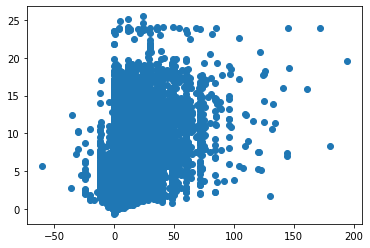

In [57]:
plt.scatter(y_test, y_pred)

In [58]:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          SalesQuantity   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     7636.
Date:                Fri, 01 Nov 2024   Prob (F-statistic):               0.00
Time:                        00:45:29   Log-Likelihood:            -5.6131e+06
No. Observations:             1873614   AIC:                         1.123e+07
Df Residuals:                 1873599   BIC:                         1.123e+07
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
StoreCode                  0

In [59]:
# Extract and interpret the coefficients to find the largest effect
coefficients = model.params
coefficients_sorted = coefficients.sort_values(ascending=False)
print("Largest factors affecting sales change during promotions:")
print(coefficients_sorted.head())

Largest factors affecting sales change during promotions:
Month                     4.259795
ProductCategory_Fast      2.511969
ProductCategory_Medium    0.652767
StoreCategory_Fast        0.475549
Promotion_Promo4          0.175385
dtype: float64


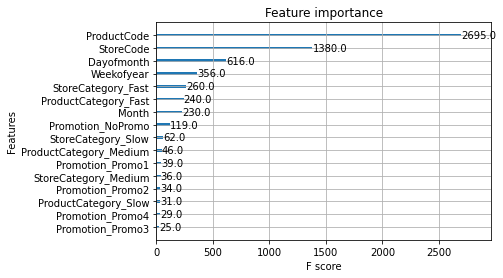

                   Feature  Importance
13    ProductCategory_Fast    0.475851
1              ProductCode    0.149099
16      StoreCategory_Fast    0.101565
6        Promotion_NoPromo    0.061291
18      StoreCategory_Slow    0.040112
14  ProductCategory_Medium    0.035424
17    StoreCategory_Medium    0.024105
0                StoreCode    0.022262
2                    Month    0.019093
4               Dayofmonth    0.016807
5               Weekofyear    0.016461
8         Promotion_Promo2    0.009824
15    ProductCategory_Slow    0.008959
7         Promotion_Promo1    0.008362
9         Promotion_Promo3    0.006533
10        Promotion_Promo4    0.004253
11        Promotion_Promo5    0.000000
12        Promotion_Promo6    0.000000
3                     Year    0.000000


In [60]:
# Get feature importance
importance = best_model.feature_importances_

# Plot feature importance
plot_importance(best_model)
plt.show()

# To print the feature importance in a sorted way
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

## f.	Is there any significant difference between promotion impacts of the Fast versus Slow items?

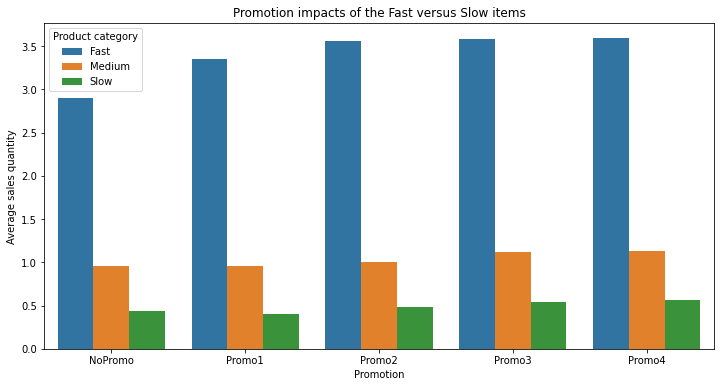

In [61]:
# Fast and slow items based on promotion periods
product_categories = assignment4_1a_df.groupby(['Promotion', 'ProductCategory'])['SalesQuantity'].mean().reset_index()

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Promotion', y='SalesQuantity', hue='ProductCategory', data=product_categories)
plt.title('Promotion impacts of the Fast versus Slow items')
plt.ylabel('Average sales quantity')
plt.xlabel('Promotion')
plt.legend(title='Product category')
plt.show()

In [62]:
#A/B Test
fast_products = assignment4_1a_df[assignment4_1a_df['ProductCategory'] == 'Fast']
slow_products = assignment4_1a_df[assignment4_1a_df['ProductCategory'] == 'Slow']


fast_promo_sales = fast_products[fast_products['Promotion'] != 'NoPromo']['SalesQuantity']
slow_promo_sales = slow_products[slow_products['Promotion'] != 'NoPromo']['SalesQuantity']

# T-Test
t_stat, p_value = ttest_ind(fast_promo_sales, slow_promo_sales)

print(f"T-Stat: {t_stat}, P-Value: {p_value}")

T-Stat: 48.431044497765235, P-Value: 0.0


## g.	Is there any significant difference between promotion impacts of the Fast versus Slow stores?

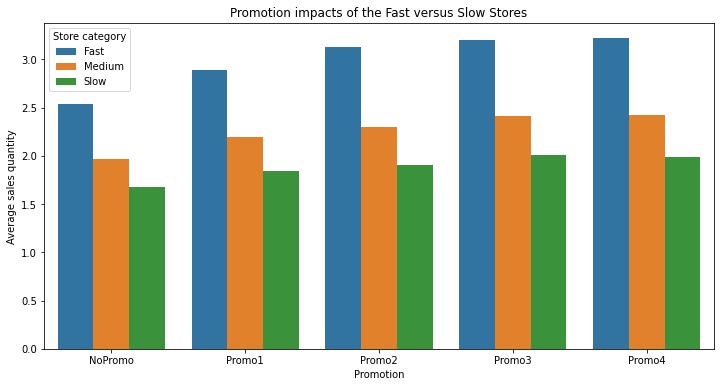

In [63]:
# Fast and slow items based on promotion periods
product_categories = assignment4_1a_df.groupby(['Promotion', 'StoreCategory'])['SalesQuantity'].mean().reset_index()

# Bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Promotion', y='SalesQuantity', hue='StoreCategory', data=product_categories)
plt.title('Promotion impacts of the Fast versus Slow Stores')
plt.ylabel('Average sales quantity')
plt.xlabel('Promotion')
plt.legend(title='Store category')
plt.show()

In [64]:
# Same approach for stores
fast_stores = assignment4_1a_df[assignment4_1a_df['StoreCategory'] == 'Fast']
slow_stores = assignment4_1a_df[assignment4_1a_df['StoreCategory'] == 'Slow']
fast_promo_sales_store = fast_stores[fast_stores['Promotion'] != 'NoPromo']['SalesQuantity']
slow_promo_sales_store = slow_stores[slow_stores['Promotion'] != 'NoPromo']['SalesQuantity']

t_stat_store, p_value_store = ttest_ind(fast_promo_sales_store, slow_promo_sales_store)
print(f"T-Stat for Fast and Slow stores: {t_stat_store}, P-Value: {p_value_store}")

T-Stat for Fast and Slow stores: 41.56999728502101, P-Value: 0.0


## Model B Promotion5

In [65]:
promotion_dates_df

,Period,StartDate,EndDate
0,Promo1,2015-02-10 00:00:00,2015-02-17 00:00:00
1,Promo2,2015-03-15 00:00:00,2015-03-22 00:00:00
2,Promo3,2015-05-24 00:00:00,2015-06-01 00:00:00
3,Promo4,2015-06-21 00:00:00,2015-06-28 00:00:00
4,Promo5,2015-09-01 00:00:00,2015-09-06 00:00:00
5,Promo6,2015-11-20 00:00:00,2015-11-27 00:00:00


In [66]:
assignment4_1b_df = pd.read_csv("assignment4.1b.csv")
# Convert dates to date format
assignment4_1b_df['Date'] = pd.to_datetime(assignment4_1b_df['Date'], format='%Y/%m/%d', errors='coerce')
#Based on second dataset's dates adding promotion dates to main dataset
assignment4_1b_df = pd.merge(assignment4_1b_df, promo_expanded, on='Date', how='left')

# Not promotion days named as NoPromo
assignment4_1b_df['Promotion'].fillna('NoPromo', inplace=True)

print(assignment4_1b_df.tail())

              Date  StoreCode  ProductCode  SalesQuantity Promotion
1028116 2016-01-01        340          247              5   NoPromo
1028117 2016-01-01        340          264              1   NoPromo
1028118 2016-01-01        340          292              1   NoPromo
1028119 2016-01-01        340          305              1   NoPromo
1028120 2016-01-01        340          313              1   NoPromo


In [67]:
assignment4_1b_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1028121 entries, 0 to 1028120
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Date           1028121 non-null  datetime64[ns]
 1   StoreCode      1028121 non-null  int64         
 2   ProductCode    1028121 non-null  int64         
 3   SalesQuantity  1028121 non-null  int64         
 4   Promotion      1028121 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 47.1+ MB


In [68]:
assignment4_1b_df.Promotion.unique()

array(['NoPromo', 'Promo5', 'Promo6 '], dtype=object)

In [69]:
real_observed_sales_p5 = assignment4_1b_df[(assignment4_1b_df["Date"]>= "2015-09-01") & ((assignment4_1b_df["Date"]<= "2015-09-06")) ]
real_observed_sales_p5

,Date,StoreCode,ProductCode,SalesQuantity,Promotion
233877,2015-09-01,1,25,1,Promo5
233878,2015-09-01,1,37,1,Promo5
233879,2015-09-01,1,38,1,Promo5
233880,2015-09-01,1,46,1,Promo5
233881,2015-09-01,1,71,2,Promo5
...,...,...,...,...,...
275347,2015-09-06,340,224,1,Promo5
275348,2015-09-06,340,232,1,Promo5
275349,2015-09-06,340,288,2,Promo5
275350,2015-09-06,340,305,1,Promo5


In [70]:
assignment4_1b_df["Month"] = assignment4_1b_df["Date"].dt.month
assignment4_1b_df["Year"] = assignment4_1b_df["Date"].dt.year
assignment4_1b_df["Dayofmonth"] = assignment4_1b_df["Date"].dt.day
assignment4_1b_df["Weekofyear"] = assignment4_1b_df["Date"].dt.week

# Sales at non-promotion periods
non_promo_salesb = assignment4_1b_df[assignment4_1b_df['Promotion'] == 'NoPromo']

# Weekly_sales of each product
weekly_salesb = non_promo_salesb.groupby(['ProductCode', "Weekofyear"])['SalesQuantity'].sum().reset_index()

# Weekly mean sales for each product
average_sales_per_productb = weekly_salesb.groupby('ProductCode')['SalesQuantity'].mean().reset_index()
average_sales_per_productb.columns = ['ProductCode', 'AvgWeeklySales']

# Seperating fast, medium and slow items
average_sales_per_productb['Rank'] = average_sales_per_productb['AvgWeeklySales'].rank(ascending=False)
average_sales_per_productb['Category'] = pd.qcut(average_sales_per_productb['Rank'], 3, labels=['Fast', 'Medium', 'Slow'])

# Weekly_sales of each store
weekly_sales_storeb = non_promo_salesb.groupby(['StoreCode', "Weekofyear"])['SalesQuantity'].sum().reset_index()

# Weekly mean sales for each store
average_sales_per_storeb = weekly_sales_storeb.groupby('StoreCode')['SalesQuantity'].mean().reset_index()
average_sales_per_storeb.columns = ['StoreCode', 'AvgWeeklySales']

# Seperating fast, medium and slow items
average_sales_per_storeb['Rank'] = average_sales_per_storeb['AvgWeeklySales'].rank(ascending=False)
average_sales_per_storeb['Category'] = pd.qcut(average_sales_per_storeb['Rank'], 3, labels=['Fast', 'Medium', 'Slow'])


# Combining product groups with the data
assignment4_1b_df = assignment4_1b_df.merge(average_sales_per_productb[['ProductCode', 'Category']], on='ProductCode', how='left')
assignment4_1b_df.rename(columns={'Category': 'ProductCategory'}, inplace=True)

# Combining store groups with the data
assignment4_1b_df = assignment4_1b_df.merge(average_sales_per_storeb[['StoreCode', 'Category']], on='StoreCode', how='left')
assignment4_1b_df.rename(columns={'Category': 'StoreCategory'}, inplace=True)



print(assignment4_1b_df.head())

        Date  StoreCode  ProductCode  SalesQuantity Promotion  Month  Year  \
0 2015-08-01          2            9              1   NoPromo      8  2015   
1 2015-08-01          7            9              1   NoPromo      8  2015   
2 2015-08-01         62            9              1   NoPromo      8  2015   
3 2015-08-01        181            9              1   NoPromo      8  2015   
4 2015-08-01          6           20              1   NoPromo      8  2015   

   Dayofmonth  Weekofyear ProductCategory StoreCategory  
0           1          31            Slow          Fast  
1           1          31            Slow          Fast  
2           1          31            Slow          Fast  
3           1          31            Slow          Fast  
4           1          31            Fast          Fast  


In [71]:
assignment4_1a_df_model.columns

Index(['Date', 'StoreCode', 'ProductCode', 'SalesQuantity', 'Promotion',
       'Month', 'Year', 'Dayofmonth', 'Weekofyear', 'ProductCategory',
       'StoreCategory', 'Promotion_NoPromo', 'Promotion_Promo1',
       'Promotion_Promo2', 'Promotion_Promo3', 'Promotion_Promo4',
       'Promotion_Promo5', 'Promotion_Promo6', 'ProductCategory_Fast',
       'ProductCategory_Medium', 'ProductCategory_Slow', 'StoreCategory_Fast',
       'StoreCategory_Medium', 'StoreCategory_Slow'],
      dtype='object')

In [72]:
dummies_promo = pd.get_dummies(assignment4_1b_df[["Promotion"]])
dummies_cat = pd.get_dummies(assignment4_1b_df[["ProductCategory","StoreCategory"]])
assignment4_1b_df_model = assignment4_1b_df.copy()
assignment4_1b_df_model = pd.concat([assignment4_1b_df_model, dummies_promo],axis=1)
assignment4_1b_df_model = assignment4_1b_df_model.assign(Promotion_Promo1=0, Promotion_Promo2=0, Promotion_Promo3=0, Promotion_Promo4=0)
assignment4_1b_df_model = assignment4_1b_df_model.rename(columns={"Promotion_Promo6 ":"Promotion_Promo6"})

columnsb = list(assignment4_1b_df_model.columns[:-6])+['Promotion_Promo1', 'Promotion_Promo2', 
           'Promotion_Promo3', 'Promotion_Promo4', 'Promotion_Promo5', 'Promotion_Promo6']

assignment4_1b_df_model = assignment4_1b_df_model[columnsb]


assignment4_1b_df_model = pd.concat([assignment4_1b_df_model, dummies_cat],axis=1)
Xb = assignment4_1b_df_model.drop(["Date","SalesQuantity","Promotion","ProductCategory","StoreCategory"],axis=1)
yb = assignment4_1b_df_model['SalesQuantity']

# Test
best_model = grid_search.best_estimator_
y_predb = best_model.predict(Xb)

In [83]:
Xb[Xb.Promotion_Promo5 == 1]

,StoreCode,ProductCode,Month,Year,Dayofmonth,Weekofyear,Promotion_NoPromo,Promotion_Promo1,Promotion_Promo2,Promotion_Promo3,Promotion_Promo4,Promotion_Promo5,Promotion_Promo6,ProductCategory_Fast,ProductCategory_Medium,ProductCategory_Slow,StoreCategory_Fast,StoreCategory_Medium,StoreCategory_Slow
233877,1,25,9,2015,1,36,0,0,0,0,0,1,0,0,1,0,0,1,0
233878,1,37,9,2015,1,36,0,0,0,0,0,1,0,0,1,0,0,1,0
233879,1,38,9,2015,1,36,0,0,0,0,0,1,0,0,1,0,0,1,0
233880,1,46,9,2015,1,36,0,0,0,0,0,1,0,0,1,0,0,1,0
233881,1,71,9,2015,1,36,0,0,0,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275347,340,224,9,2015,6,36,0,0,0,0,0,1,0,0,1,0,1,0,0
275348,340,232,9,2015,6,36,0,0,0,0,0,1,0,1,0,0,1,0,0
275349,340,288,9,2015,6,36,0,0,0,0,0,1,0,1,0,0,1,0,0
275350,340,305,9,2015,6,36,0,0,0,0,0,1,0,1,0,0,1,0,0


In [73]:
real_observed_sales_p5

,Date,StoreCode,ProductCode,SalesQuantity,Promotion
233877,2015-09-01,1,25,1,Promo5
233878,2015-09-01,1,37,1,Promo5
233879,2015-09-01,1,38,1,Promo5
233880,2015-09-01,1,46,1,Promo5
233881,2015-09-01,1,71,2,Promo5
...,...,...,...,...,...
275347,2015-09-06,340,224,1,Promo5
275348,2015-09-06,340,232,1,Promo5
275349,2015-09-06,340,288,2,Promo5
275350,2015-09-06,340,305,1,Promo5


In [74]:
predicted_yb_df = pd.DataFrame(data = y_predb, index = assignment4_1b_df_model["Date"])
predicted_yb_df = predicted_yb_df[(predicted_yb_df.index >= "2015-09-01") & (predicted_yb_df.index <= "2015-09-06")]
predicted_yb_df

,0
Date,
2015-09-01,0.602539
2015-09-01,0.215712
2015-09-01,0.215712
2015-09-01,0.233482
2015-09-01,0.933239
...,...
2015-09-06,-0.189636
2015-09-06,-0.256666
2015-09-06,0.693304


Text(0, 0.5, 'Prediction')

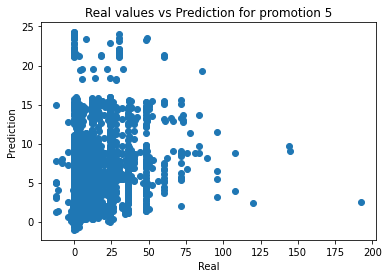

In [81]:
plt.scatter(real_observed_sales_p5["SalesQuantity"].values, predicted_yb_df.values)
plt.title("Real values vs Prediction for promotion 5")
plt.xlabel("Real")
plt.ylabel("Prediction")

In [75]:
# Mean squared error
mse5 = mean_squared_error(real_observed_sales_p5["SalesQuantity"].values, predicted_yb_df.values)
# R-squared (R²)
r2_promo5 = r2_score(real_observed_sales_p5["SalesQuantity"].values, predicted_yb_df.values)
print(f"Mean Squared Error: {mse5}")
print(f"R-squared: {r2_promo5}")

Mean Squared Error: 29.342592494905382
R-squared: 0.1662715627875475


### What measure would you use for goodness of fit?

### How good is your model developed in step 1?

### What are the main problem points causing bad fits?

### What would you change in step 1?

## Bonus: Is there any significant difference in item return rates after promotions?

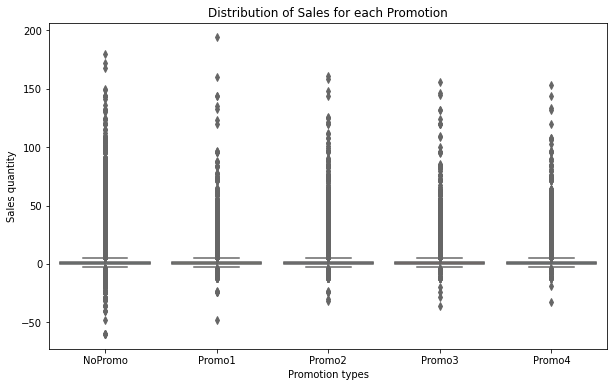

In [76]:
# Distribution of Sales for each Promotion
plt.figure(figsize=(10, 6))
sns.boxplot(x='Promotion', y='SalesQuantity', data=assignment4_1a_df, palette='Set3')
plt.title('Distribution of Sales for each Promotion')
plt.ylabel('Sales quantity')
plt.xlabel('Promotion types')
plt.show()